<a href="https://colab.research.google.com/github/GOGIREDDY007/College-Admission-Q-A-Bot/blob/main/Hyperspectral_Analysis(Visualization)_%2B_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading Indian pines hyperspecral dataset:

In [ ]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"


!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"

--2020-08-19 08:03:53--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   350KB/s    in 20s     

2020-08-19 08:04:14 (290 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-08-19 08:04:16--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-08-19 08:04:16 (146 MB/s) - ‘Indian_pines_gt.

### Useful imports

In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

In [ ]:
!ls


drive			    Indian_pines_corrected.mat.1  sample_data
Indian_pines_corrected.mat  Indian_pines_gt.mat


In [ ]:

## Importing Library.
from scipy.io import loadmat

In [ ]:

dataset = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:

#The dimensions of the data.
print(f'Dataset: {dataset.shape}\nGround Truth: {ground_truth.shape}')
#print(f'Dataset1: {dataset1.shape}\nGround Truth1: {ground_truth1.shape}')

Dataset: (145, 145, 200)
Ground Truth: (145, 145)


Data visualization:

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    band_no = np.random.randint(dataset.shape[2])
    plt.imshow(dataset[:,:, band_no], cmap='viridis')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()

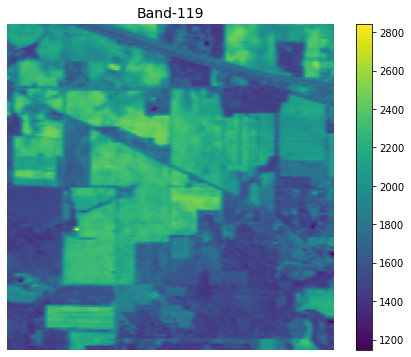

In [ ]:
plot_band(dataset)

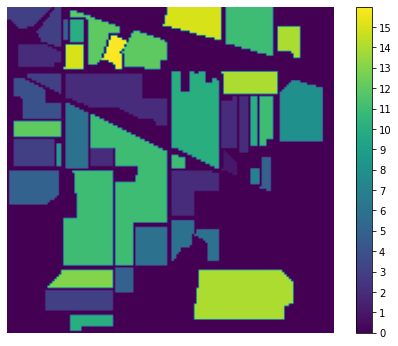

In [ ]:

plt.figure(figsize=(8, 6))
plt.imshow(ground_truth, cmap='viridis')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()

### Extracting Band Information:

In [ ]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [ ]:
df = extract_pixels(dataset, ground_truth)
df.head()

100%|██████████| 200/200 [00:00<00:00, 318.30it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [ ]:
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,3762,3696,3594,3750,3806,3764,3655,2611,3199,3036,2978,2837,2758,2650,2617,2494,2397,2366,2313,2198,2464,2261,2490,3124,3643,4349,5748,6973,7199,5067,...,1082,1079,1077,1086,1071,1084,1079,1076,1082,1077,1082,1078,1077,1068,1070,1053,1063,1055,1052,1047,1042,1043,1031,1025,1034,1029,1026,1025,1018,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,3786,3696,3623,3726,3758,3725,3614,2584,3174,3042,2958,2837,2769,2626,2617,2484,2387,2362,2322,2199,2463,2188,2444,3077,2808,4239,5706,6965,7227,5108,...,1086,1076,1086,1081,1069,1086,1078,1081,1078,1075,1084,1087,1082,1071,1064,1059,1063,1051,1049,1042,1042,1043,1031,1029,1029,1026,1021,1026,1021,1023,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,3890,3683,3594,3714,3724,3700,2809,2564,3177,3031,2925,2837,2719,2605,2603,2476,2373,2335,2308,2198,2449,2164,2443,

In [ ]:
df.to_csv('Dataset.csv', index=False)

In [ ]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

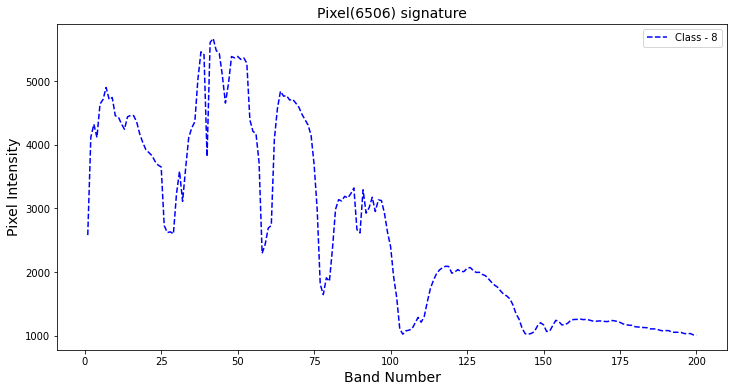

In [ ]:
plot_signature(df)

In [ ]:
ls

Dataset.csv  Indian_pines_corrected.mat    Indian_pines_gt.mat
drive/       Indian_pines_corrected.mat.1  sample_data/


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df.sample(6)

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
16807,3324,4222,4199,4100,4214,4379,4372,4251,4157,3841,3767,3694,3610,3741,3714,3711,2810,2589,3190,2998,2953,2854,2766,2666,2655,2525,2414,2365,2344,2210,2472,2260,2517,3032,2693,3989,4992,5924,6108,4245,...,1082,1077,1077,1076,1070,1075,1077,1072,1078,1069,1077,1075,1076,1067,1068,1057,1053,1048,1038,1045,1047,1046,1038,1034,1018,1025,1026,1019,1023,1015,1014,1011,1021,1011,1006,1010,1011,1004,1009,0
18968,3322,3857,4100,3952,4209,4428,4414,4218,4074,3860,3793,3638,2779,3707,3695,3671,3592,2606,3174,3062,2973,2861,2771,2684,2605,2508,2411,2402,2337,2247,2487,2312,2496,3012,2745,4218,5539,6652,6749,4708,...,1078,1076,1084,1084,1076,1078,1068,1072,1078,1076,1075,1076,1078,1065,1060,1055,1064,1060,1048,1042,1044,1042,1039,1039,1021,1030,1024,1022,1024,1027,1016,1008,1015,1022,1010,1015,1020,1001,1000,14
4996,3173,3880,4140,3967,4165,4382,4520,4302,4226,3946,3878,3875,3740,3961,3996,3967,3850,3684,2766,2622,3325,3236,3155,3116,3008,2929,2816,2775,2750,2620,2954,2416,2833,2612,3740,4123,5002,5770,5828,4115,...,1145,1135,1142,1141,1143,1131,1142,1134,1136,1129,1144,1140,1133,1131,1125,1110,1099,1098,1086,1097,1087,1076,1078,1071,1061,1064,1053,1044,1039,1048,1040,1032,1034,1017,1023,1023,1018,1016,1010,0
9923,2607,4252,4318,4265,4770,5035,5158,5079,5062,4810,4859,4798,4703,4868,4941,4959,4884,4816,4736,4706,4691,4727,4678,4651,4706,4674,4553,4712,4710,4383,4534,4256,4586,4814,4707,4583,5110,5442,5353,3773,...,1440,1444,1441,1432,1404,1395,1385,1379,1374,1366,1374,1387,1363,1337,1323,1297,1290,1280,1262,1260,1260,1227,1231,1202,1192,1198,1157,1147,1136,1140,1110,1110,1122,1089,1070,1084,1046,1028,1009,11
6120,2581,4249,4414,4334,4655,4874,5021,4917,4937,4618,4713,4598,4537,4675,4699,4754,4627,4455,4386,4247,4244,4233,4192,4078,4081,4044,3886,3985,3968,3698,3930,3710,3902,4309,4337,4355,5027,5544,5441,3860,...,1308,1305,1304,1313,1286,1279,1270,1270,1263,1259,1268,1269,1252,1239,1215,1206,1199,1205,1183,1176,1168,1158,1148,1137,1118,1124,1103,1105,1100,1102,1072,1082,1072,1069,1042,1052,1035,1024,1009,0
14466,2842,3975,3928,3885,4046,4275,4279,4128,4005,3713,3664,3589,2727,3607,3723,3650,2765,3264,3093,2959,2868,2764,2680,2557,2550,2429,2321,2282,2256,2123,2411,2137,2443,3051,3675,4376,5756,6921,7080,4994,...,1073,1076,1072,1077,1073,1066,1078,1065,1069,1074,1077,1072,1067,1063,1058,1053,1048,1047,1033,1043,1041,1030,1039,1032,1025,1030,1020,1014,1015,1012,1011,1012,1002,1010,1010,1000,1002,1000,995,0


In [ ]:
print(f'Shape of the data: {df.shape}')

Shape of the data: (21025, 201)


### Band Information visualization:

In [ ]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [ 3  0 15 11 12  5 10 14 16  2  4  8  6  9  1  7 13]


In [ ]:
df.loc[:, 'class'].value_counts()

0     10776
11     2455
2      1428
14     1265
10      972
3       830
6       730
12      593
5       483
8       478
15      386
4       237
13      205
16       93
1        46
7        28
9        20
Name: class, dtype: int64

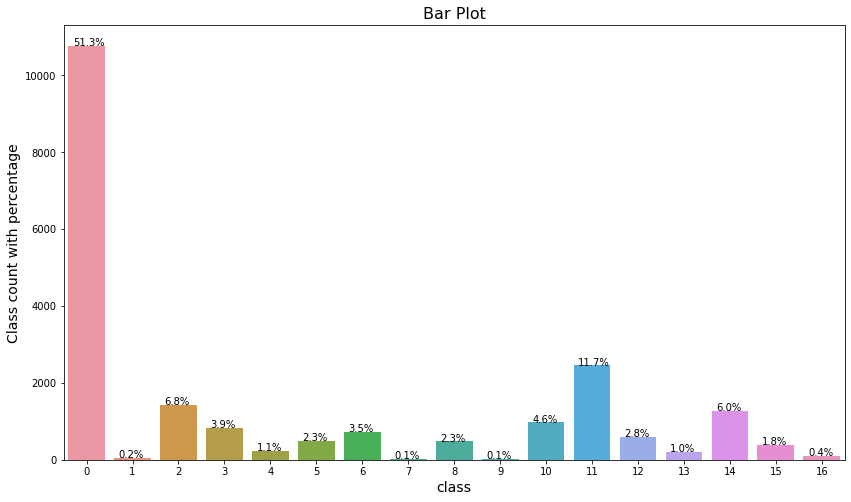

In [ ]:

plt.figure(figsize=(14, 8))

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.ylabel('Class count with percentage', fontsize=14)

plt.xlabel('class', fontsize=14)

plt.title('Bar Plot', fontsize=16)

plt.show()

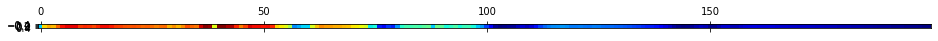

In [ ]:
# Visualizing the pixel
plt.matshow(df.iloc[1, :-1].values.reshape(1,200), cmap='jet');

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_pixel(pixel, n):
    ax = plt.gca()
    im = ax.imshow(pixel.reshape(10, 20), cmap = 'jet')
    plt.title(f'pixel - {n}')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

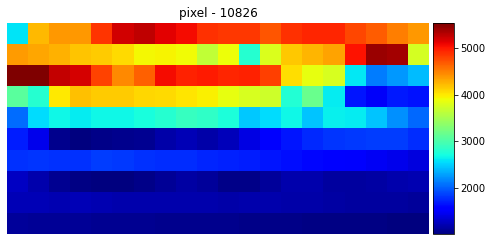

In [ ]:
plt.figure(figsize=(8, 4))

rand_n = np.random.randint(df.shape[0])

plot_pixel(df.iloc[rand_n, :-1].values, rand_n)

Enter the band Number(1-200) :76


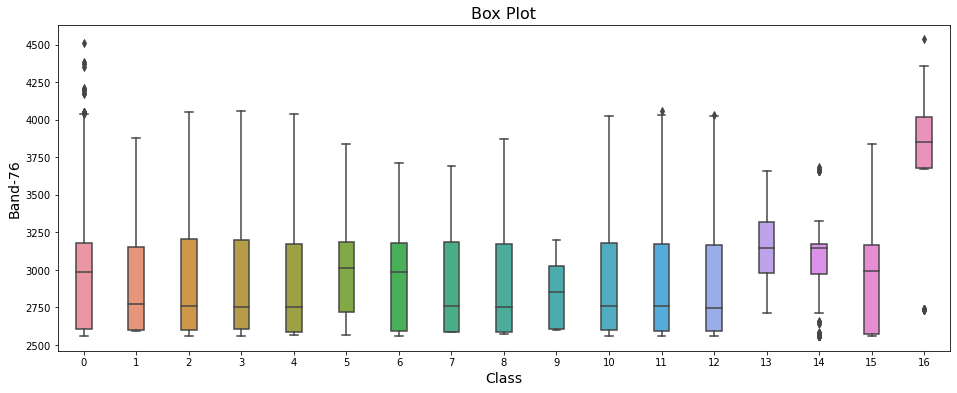

In [ ]:
plt.figure(figsize=(16, 6))
n = int(input('Enter the band Number(1-200) :'))
sns.boxplot( x=df["class"], y=df["band-1"], width=0.3);
plt.title('Box Plot', fontsize= 16)
plt.xlabel('Class', fontsize= 14)
plt.ylabel(f'Band-{n}', fontsize= 14)
plt.show()

In [ ]:
print(f"Details of Band - {n}: \n\n{df['band-'+str(n)].describe()}")

Details of Band - 76: 

count    21025.000000
mean      2911.013127
std        226.445691
min       1542.000000
25%       2770.000000
50%       2909.000000
75%       3069.000000
max       3920.000000
Name: band-76, dtype: float64


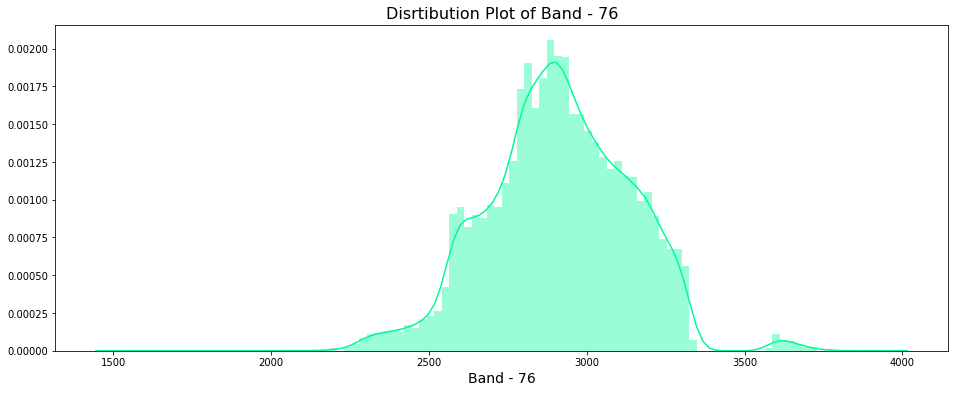

In [ ]:

plt.figure(figsize=(16, 6))
sns.distplot(df['band-'+str(n)], color='mediumSpringGreen', bins=100, hist_kws={'alpha': 0.4});
plt.xlabel('Band - '+str(n), fontsize=14)
plt.title('Disrtibution Plot of Band - '+str(n), fontsize=16)
plt.show()

### Implemetation of Dimensionality reduction using truncated SVD

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# !pip install seaborn
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('Dataset.csv')
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,3762,3696,3594,3750,3806,3764,3655,2611,3199,3036,2978,2837,2758,2650,2617,2494,2397,2366,2313,2198,2464,2261,2490,3124,3643,4349,5748,6973,7199,5067,...,1082,1079,1077,1086,1071,1084,1079,1076,1082,1077,1082,1078,1077,1068,1070,1053,1063,1055,1052,1047,1042,1043,1031,1025,1034,1029,1026,1025,1018,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,3786,3696,3623,3726,3758,3725,3614,2584,3174,3042,2958,2837,2769,2626,2617,2484,2387,2362,2322,2199,2463,2188,2444,3077,2808,4239,5706,6965,7227,5108,...,1086,1076,1086,1081,1069,1086,1078,1081,1078,1075,1084,1087,1082,1071,1064,1059,1063,1051,1049,1042,1042,1043,1031,1029,1029,1026,1021,1026,1021,1023,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,3890,3683,3594,3714,3724,3700,2809,2564,3177,3031,2925,2837,2719,2605,2603,2476,2373,2335,2308,2198,2449,2164,2443,

In [ ]:
X = df.iloc[:, :-1].values

y = df.iloc[:, -1].values



In [ ]:
X.shape, y.shape

((21025, 200), (21025,))

In [ ]:
#kpca = KernelPCA(n_components = 50, kernel='poly', eigen_solver='arpack')
kpca = PCA(n_components=50, whiten=True)
#pca = PCA(n_components=numComponents, svd_solver='arpack')
principalComponents = kpca.fit_transform(X)

principalComponents.shape

(21025, 50)

In [ ]:


X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, y,  range(X.shape[0]),
                                                                                  test_size = 0.15, random_state = 11)

In [ ]:
X_train.shape, X_test.shape

((17871, 50), (3154, 50))

In [ ]:

svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=7168, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=11, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100}%')


Accuracy: 74.76220672162334%


In [57]:
! pip install -q scikit-plot

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test,
    y_pred,
    figsize=(12,12));


ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.11/dist-packages/scipy/__init__.py)

In [46]:
# print(confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_test,y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1613
           1       0.00      0.00      0.00         8
           2       0.62      0.74      0.67       228
           3       0.77      0.40      0.52       116
           4       0.80      0.18      0.29        45
           5       0.94      0.69      0.80        74
           6       0.90      0.82      0.86       115
           7       0.00      0.00      0.00         4
           8       0.79      0.91      0.85        70
           9       0.00      0.00      0.00         2
          10       0.80      0.62      0.70       139
          11       0.65      0.77      0.70       336
          12       0.78      0.32      0.45       101
          13       0.94      0.94      0.94        36
          14       0.67      0.33      0.44       189
          15       0.00      0.00      0.00        57
          16       0.73      0.38      0.50        21

  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



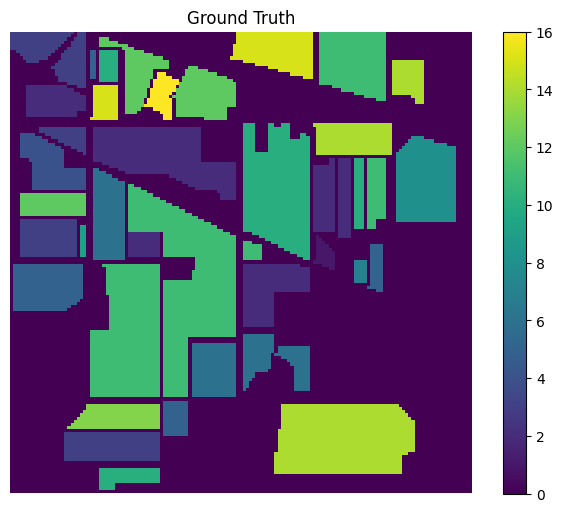

In [47]:

plt.figure(figsize=(8, 6))
plt.imshow(df.iloc[:, -1].values.reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Ground Truth')
plt.savefig('ground_truth.png')
plt.show()

In [48]:
# !pip install tqdm
from tqdm import tqdm
pre = y_pred

clmap = [0]*X.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = y[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 3154/3154 [00:00<00:00, 300696.34it/s]


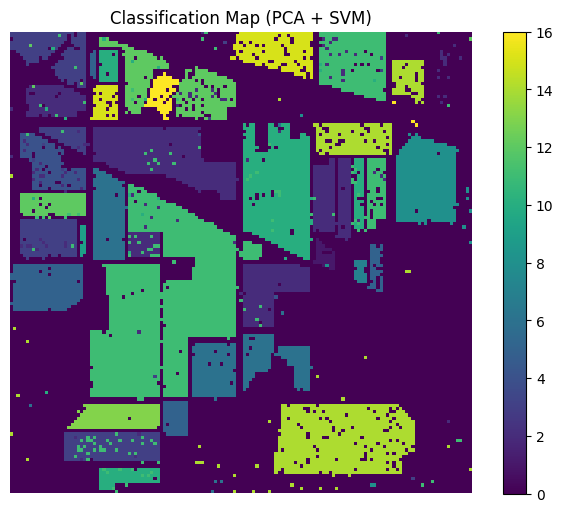

In [49]:
plt.figure(figsize=(8, 6))
plt.imshow(np.array(clmap).reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Classification Map (PCA + SVM)')
plt.savefig('Classification_map.png')
plt.show()